In [13]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from classname import class_names
from Visualize_data import visualize_image_and_label, visualize_random_images
from tqdm import tqdm


In [97]:
#count the number of images in the data directory
def count_images(data_dir):
    images = [f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    return len(images)

data_dir_train = 'data_aug/train/images'
data_dir_test = 'data_aug/test/images'
data_dir_val = 'data_aug/valid/images'
print(f'train: {count_images(data_dir_train)}')
print(f'test: {count_images(data_dir_test)}')
print(f'valid: {count_images(data_dir_val)}')


train: 6544
test: 231
valid: 491


train: 1,636
test: 231
vail: 491

train 7,
test 1,
valid 2,
total 10


Augmentation Train


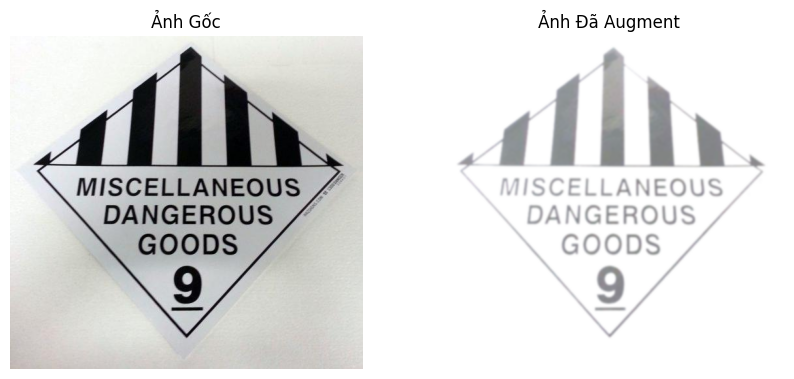

In [98]:
#ban đêm
# transform = A.Compose([
#     A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.3), contrast_limit=(-0.2, -0.2), p=1), 
#     A.GaussianBlur(blur_limit=(3, 7), p=1), 
#     A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=-50, val_shift_limit=-30, p=1),  
# ])

#trời nắng to
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(0.4, 0.6), contrast_limit=(0.3, 0.5), p=1), 
    A.GaussianBlur(blur_limit=(3, 7), p=1), 
])

image = cv2.imread("Hazmat Placards.v1i.yolov11/train/images/0c93c378e8_jpg.rf.adb3ef1a8039aff9909d9bd00101e18c.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transformed = transform(image=image)
transformed_image = transformed["image"]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Ảnh Gốc')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.title('Ảnh Đã Augment')
plt.axis('off')

plt.show()

Visualize data augmentation

['31 0.469140625 0.3046875 0.14140625 0.18229166666666666\n', '11 0.47109375 0.4744791666666667 0.1328125 0.16770833333333332\n', '6 0.347265625 0.48020833333333335 0.13828125 0.16875\n', '16 0.3375 0.3104166666666667 0.1421875 0.17291666666666666\n']


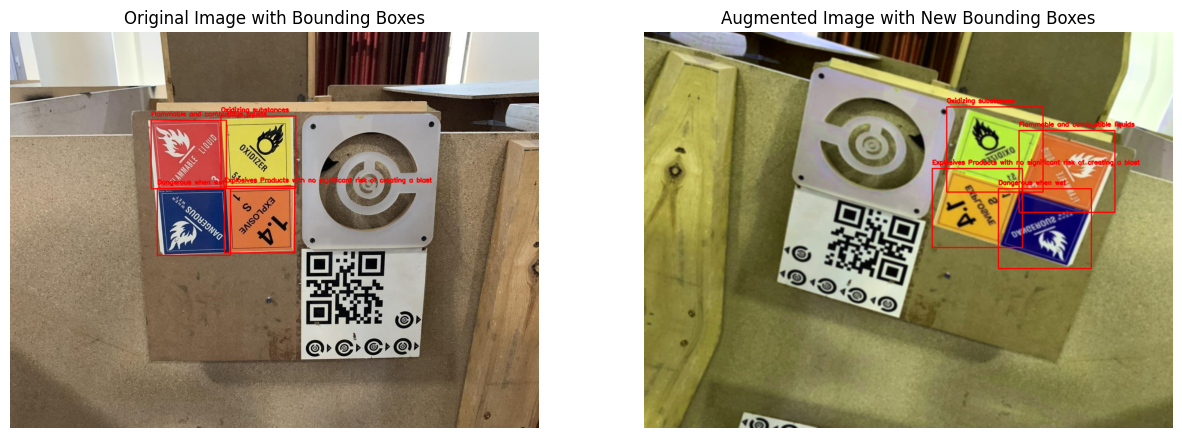

Original bounding boxes: [[0.469140625, 0.3046875, 0.14140625, 0.18229166666666666], [0.47109375, 0.4744791666666667, 0.1328125, 0.16770833333333332], [0.347265625, 0.48020833333333335, 0.13828125, 0.16875], [0.3375, 0.3104166666666667, 0.1421875, 0.17291666666666666]]
Augmented bounding boxes: [[0.6634629964828491, 0.2987239956855774, 0.18220148980617523, 0.21465641260147095], [0.6300650238990784, 0.44575047492980957, 0.17048102617263794, 0.19851920008659363], [0.7578402757644653, 0.4978904128074646, 0.17641761898994446, 0.201520636677742], [0.7993664741516113, 0.3538389503955841, 0.18129026889801025, 0.20668374001979828]]
Class Labels: ['Oxidizing substances', 'Explosives Products with no significant risk of creating a blast', 'Dangerous when wet', 'Flammable and combustible liquids']


In [2]:
def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.HorizontalFlip(p=0.6),
    A.RandomBrightnessContrast(p=0.6),
    A.Rotate(limit=40, p=0.8),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=1),
    A.GaussianBlur(blur_limit=(3, 7), p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

image = cv2.imread('merge_dataset/images/01_jpg.rf.c3b90d3513aa605677aa0408d41e76ce.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open('merge_dataset/labels/01_jpg.rf.c3b90d3513aa605677aa0408d41e76ce.txt', 'r') as f:
    lines = f.readlines()

print(lines)

bboxes = []
class_labels = []

for line in lines:
    values = line.strip().split()[:5]  
    class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)
    
    bboxes.append([x_center, y_center, bbox_width, bbox_height])
    class_labels.append(class_names[int(class_id)])


bboxes = [clip_bboxes(bbox) for bbox in bboxes]

augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
augmented_image = augmented['image']
augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]

def draw_bboxes(image, bboxes, class_labels=None):
    for i, bbox in enumerate(bboxes):
        x_center, y_center, bbox_width, bbox_height = bbox
        x1 = int((x_center - bbox_width / 2) * image.shape[1])
        y1 = int((y_center - bbox_height / 2) * image.shape[0])
        x2 = int((x_center + bbox_width / 2) * image.shape[1])
        y2 = int((y_center + bbox_height / 2) * image.shape[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        if class_labels and i < len(class_labels):
            cv2.putText(image, class_labels[i], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

original_image_with_bbox = image.copy()
draw_bboxes(original_image_with_bbox, bboxes, class_labels)

augmented_image_with_bbox = augmented_image.copy()
draw_bboxes(augmented_image_with_bbox, augmented_bboxes, augmented['class_labels'])

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image_with_bbox)
plt.title('Original Image with Bounding Boxes')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image_with_bbox)
plt.title('Augmented Image with New Bounding Boxes')
plt.axis('off')

plt.show()

print("Original bounding boxes:", bboxes)
print("Augmented bounding boxes:", augmented_bboxes)
print("Class Labels:", class_labels)


Augmentation 

In [83]:
source_image_folder = 'Hazmat Placards.v1i.yolov11/train/images'
source_label_folder = 'Hazmat Placards.v1i.yolov11/train/labels'
aug_image_folder = 'data_aug/train/images'
aug_label_folder = 'data_aug/train/labels'

os.makedirs(aug_image_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(p=1),
    A.Rotate(limit=40, p=1),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=1),
    A.GaussianBlur(blur_limit=(3, 7), p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for image_filename in os.listdir(source_image_folder):
    if image_filename.endswith('.jpg') or image_filename.endswith('.png'):  
        try:
            image_path = os.path.join(source_image_folder, image_filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to read image {image_filename}. Skipping.")
                continue  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

            label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
            label_path = os.path.join(source_label_folder, label_filename)

            bboxes = []
            class_labels = []

            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                values = line.strip().split() 
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

                bboxes.append([x_center, y_center, bbox_width, bbox_height])
                class_labels.append(int(class_id))  

            bboxes = [clip_bboxes(bbox) for bbox in bboxes]

            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            augmented_image = augmented['image']
            augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]
            
            original_output_path = os.path.join(aug_image_folder, image_filename)
            cv2.imwrite(original_output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  

            augmented_image_path = os.path.join(aug_image_folder, f'aug_{image_filename}')  
            cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

            original_label_path = os.path.join(aug_label_folder, label_filename)
            with open(original_label_path, 'w') as f:
                for bbox, class_id in zip(bboxes, class_labels):
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")


            augmented_label_path = os.path.join(aug_label_folder, f'aug_{label_filename}') 
            with open(augmented_label_path, 'w') as f:
                for bbox, class_id in zip(augmented_bboxes, class_labels):
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

        except Exception as e:
            print(f"Error processing {image_filename}: {e}. Skipping.")

print("Augmentation completed and images and labels are saved.")


Augmentation completed and images and labels are saved.


c:\Users\Admin\anaconda3\envs\hazardous_detection\lib\site-packages\albumentations\core\composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Check label data

['10', '0.4345000088214874', '0.7275000214576721', '0.11500000953674316', '0.11899995803833008']
Class ID: 10, Class Name: 2-3 Toxic gases
['20', '0.49449998140335083', '0.22450000047683716', '0.132999986410141', '0.11100000143051147']
Class ID: 20, Class Name: 6 Poisons
['10', '0.8149999976158142', '0.4865000247955322', '0.14600002765655518', '0.13500002026557922']
Class ID: 10, Class Name: 2-3 Toxic gases
['10', '0.03550000116229057', '0.34450000524520874', '0.07100000232458115', '0.11500000953674316']
Class ID: 10, Class Name: 2-3 Toxic gases


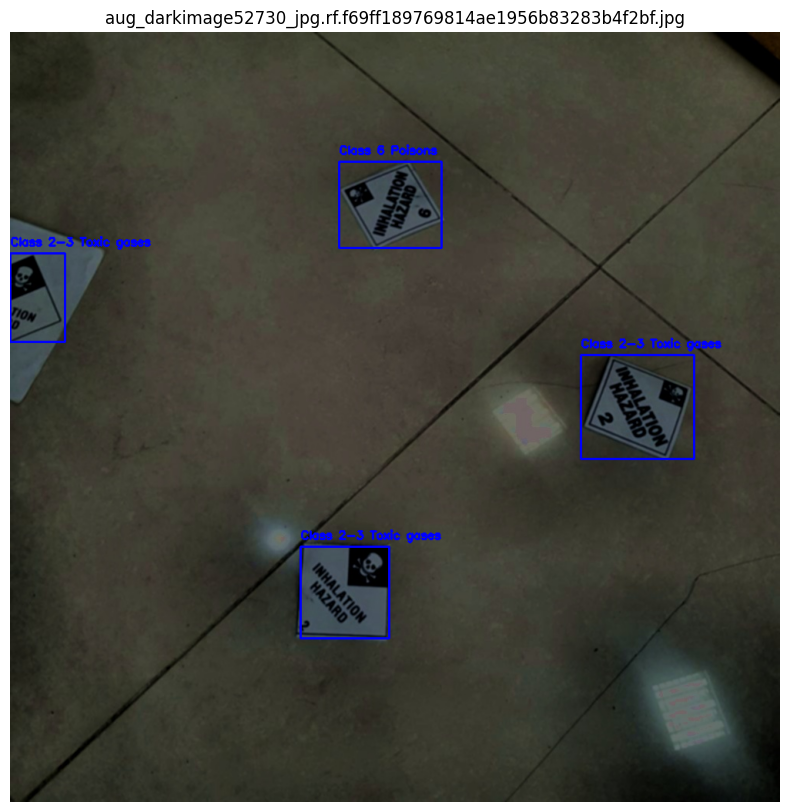

['14', '0.40914', '0.47366', '0.5449400000000001', '0.554']
Class ID: 14, Class Name: 3 Flammable liquid


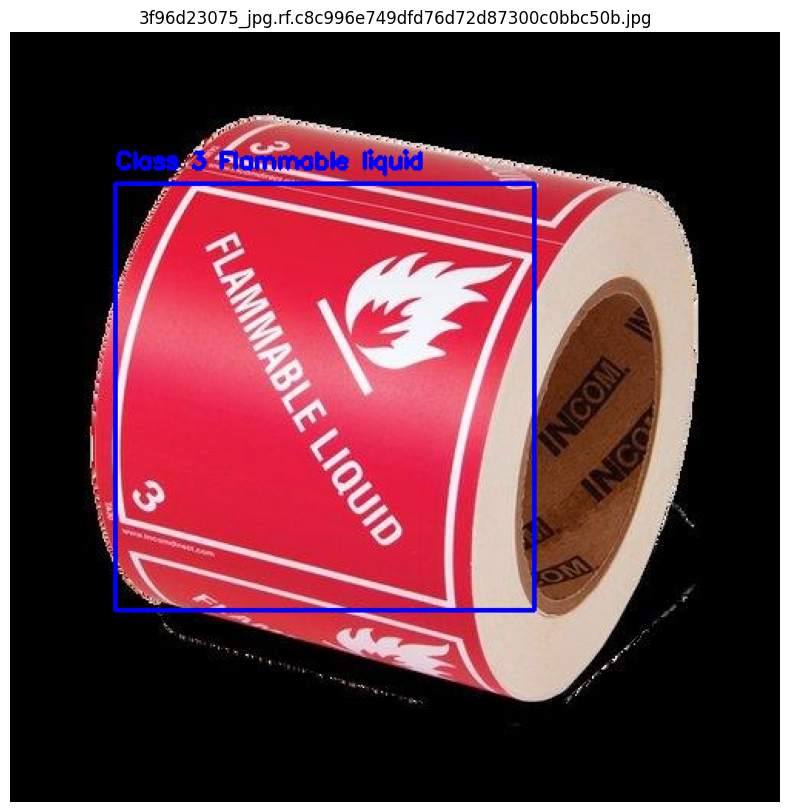

['18', '0.634375', '0.59375', '0.146875', '0.18125']
Class ID: 18, Class Name: 5-1 Oxidizing substances
['7', '0.88125', '0.6734375', '0.115625', '0.14375']
Class ID: 7, Class Name: 2 Oxygen


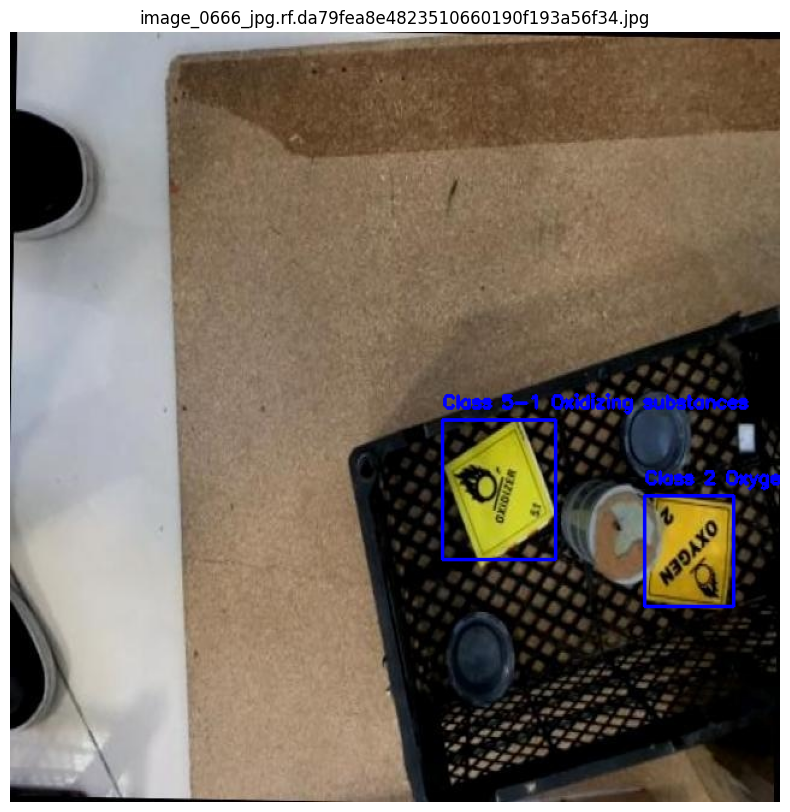

['30', '0.4742063581943512', '0.4076923131942749', '0.8214285969734192', '0.4384615421295166']
Class ID: 30, Class Name: Spontaneously combustible material


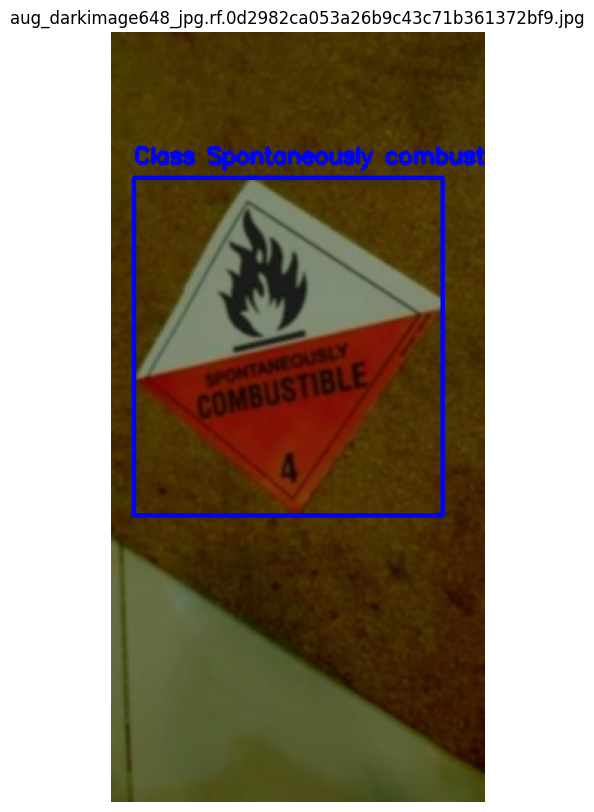

['7', '0.3234375', '0.6515625', '0.11875', '0.109375']
Class ID: 7, Class Name: 2 Oxygen
['18', '0.43046875', '0.46796875', '0.1640625', '0.1296875']
Class ID: 18, Class Name: 5-1 Oxidizing substances
['18', '0.47109375', '0.80703125', '0.1140625', '0.1234375']
Class ID: 18, Class Name: 5-1 Oxidizing substances


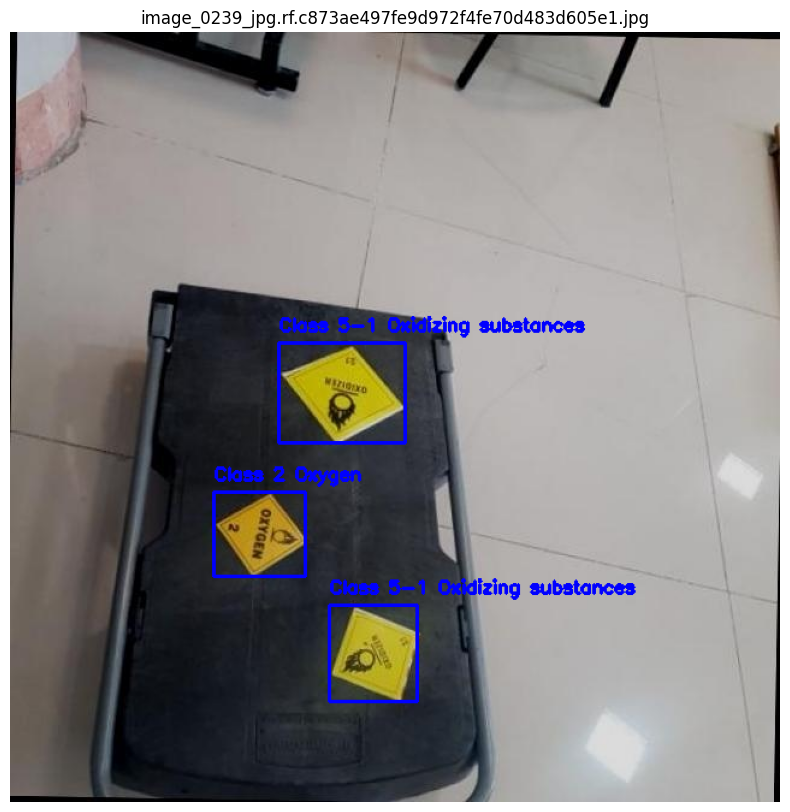

In [5]:
visualize_random_images('data_aug/train/images', 'data_aug/train/labels', class_names=class_names, num_images=5)

Add noise bouding box

In [74]:
def add_noise_to_bboxes(image, bboxes):
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox 

        bbox_region = image[y1:y2, x1:x2]

        noise = np.random.normal(0, 0.5, bbox_region.shape).astype(np.uint8) 
        noisy_bbox_region = cv2.add(bbox_region, noise)

        image[y1:y2, x1:x2] = noisy_bbox_region
    
    return image


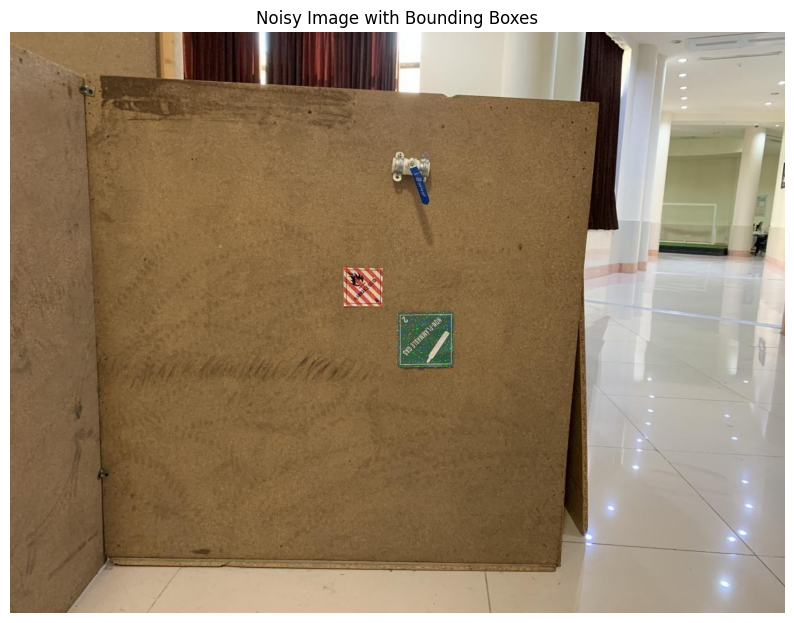

In [75]:
image = cv2.imread('data_aug/train/images/06_jpg.rf.1c5b980cde463430f9068ff8e67e9972.jpg')

bboxes = [
    [0.5359375, 0.5307291666666667, 0.0734375, 0.09895833333333333],
    [0.45546875, 0.4401041666666667, 0.0515625, 0.06770833333333333],
]

img_height, img_width, _ = image.shape
pixel_bboxes = [
    [
        int((x_center - bbox_width / 2) * img_width),
        int((y_center - bbox_height / 2) * img_height),
        int((x_center + bbox_width / 2) * img_width),
        int((y_center + bbox_height / 2) * img_height)
    ]
    for x_center, y_center, bbox_width, bbox_height in bboxes
]

noisy_image = add_noise_to_bboxes(image, pixel_bboxes)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.title('Noisy Image with Bounding Boxes')
plt.show()


augmentation image dark

In [18]:
source_image_folder = 'merged_dataset_v2/train/images'
source_label_folder = 'merged_dataset_v2/train/labels'
aug_image_folder = 'data_aug/images'
aug_label_folder = 'data_aug/labels'

os.makedirs(aug_image_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.3), contrast_limit=(-0.2, -0.2), p=1), 
        A.GaussianBlur(blur_limit=(3, 7), p=1), 
        A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=-50, val_shift_limit=-30, p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Get the list of image files
image_files = [f for f in os.listdir(source_image_folder) if f.endswith(('.jpg', '.png'))]

# Create a tqdm progress bar
for image_filename in tqdm(image_files, desc="Processing images"):
    try:
        image_path = os.path.join(source_image_folder, image_filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Unable to read image {image_filename}. Skipping.")
            continue  
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(source_label_folder, label_filename)

        bboxes = []
        class_labels = []

        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            values = line.strip().split() 
            class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

            bboxes.append([x_center, y_center, bbox_width, bbox_height])
            class_labels.append(int(class_id))  

        bboxes = [clip_bboxes(bbox) for bbox in bboxes]

        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        augmented_image = augmented['image']
        augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]
        
        augmented_image_path = os.path.join(aug_image_folder, f'aug_dark{image_filename}')  
        cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

        augmented_label_path = os.path.join(aug_label_folder, f'aug_dark{label_filename}') 
        with open(augmented_label_path, 'w') as f:
            for bbox, class_id in zip(augmented_bboxes, class_labels):
                f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

    except Exception as e:
        print(f"Error processing {image_filename}: {e}. Skipping.")

print("Augmentation completed and images and labels are saved.")

c:\Users\Admin\anaconda3\envs\hazardous_detection\lib\site-packages\albumentations\core\composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
Processing images:   0%|          | 30/6233 [00:01<05:36, 18.41it/s]

Error processing 000067_jpg.rf.856d8c1c8745412cd1d2721b771411bf.jpg: Expected x_min for bbox [-8.3371997e-06  1.2916249e-01  2.4444166e-01  6.6388750e-01
  1.4000000e+01] to be in the range [0.0, 1.0], got -8.337199687957764e-06.. Skipping.


Processing images:   2%|▏         | 153/6233 [00:09<05:33, 18.20it/s]

Error processing 35d16e7e67_jpg.rf.8ca3a3da23bc14df52461254ed852236.jpg: Expected y_max for bbox [0.0000000e+00 1.6700029e-03 1.0000000e+00 1.0000100e+00 1.2000000e+01] to be in the range [0.0, 1.0], got 1.0000100135803223.. Skipping.


Processing images:   3%|▎         | 170/6233 [00:09<03:41, 27.40it/s]

Error processing 5c869b5ea0_jpg.rf.fe5c41301c8ba45fa0311bdad4023692.jpg: Expected y_max for bbox [0.0000000e+00 1.7874837e-03 1.0000000e+00 1.0000124e+00 5.0000000e+00] to be in the range [0.0, 1.0], got 1.0000123977661133.. Skipping.


Processing images:  50%|████▉     | 3088/6233 [01:42<01:44, 30.15it/s]


KeyboardInterrupt: 

Augmentation image light

In [20]:
import random

source_image_folder = 'merged_dataset_v2/train/images'
source_label_folder = 'merged_dataset_v2/train/labels'
aug_image_folder = 'data_aug/images'
aug_label_folder = 'data_aug/labels'

os.makedirs(aug_image_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=1), 
    A.GaussianBlur(blur_limit=(3, 5), p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Get a list of all image files in the source folder
all_image_files = [f for f in os.listdir(source_image_folder) if f.endswith(('.jpg', '.png'))]

# Randomly select 3000 images or all images if there are fewer than 3000
target_images = random.sample(all_image_files, min(3000, len(all_image_files)))

for image_filename in tqdm(target_images, desc="Processing images"):
    try:
        image_path = os.path.join(source_image_folder, image_filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Unable to read image {image_filename}. Skipping.")
            continue  
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(source_label_folder, label_filename)

        bboxes = []
        class_labels = []

        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            values = line.strip().split() 
            class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

            bboxes.append([x_center, y_center, bbox_width, bbox_height])
            class_labels.append(int(class_id))  

        bboxes = [clip_bboxes(bbox) for bbox in bboxes]

        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        augmented_image = augmented['image']
        augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]
        
        augmented_image_path = os.path.join(aug_image_folder, f'aug_light_{image_filename}')  
        cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

        augmented_label_path = os.path.join(aug_label_folder, f'aug_light_{label_filename}') 
        with open(augmented_label_path, 'w') as f:
            for bbox, class_id in zip(augmented_bboxes, class_labels):
                f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

    except Exception as e:
        print(f"Error processing {image_filename}: {e}. Skipping.")

print("Light augmentation completed for randomly selected images.")


c:\Users\Admin\anaconda3\envs\hazardous_detection\lib\site-packages\albumentations\core\composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
Processing images:   1%|▏         | 44/3000 [00:03<03:42, 13.29it/s]

Error processing IMG_20231120_111211174_jpg.rf.943854a9a0a3e32a0551bbc11630a817.jpg: Expected x_min for bbox [-1.2218952e-06  1.8229167e-01  4.4352174e-01  5.2083331e-01
  3.0000000e+00] to be in the range [0.0, 1.0], got -1.2218952178955078e-06.. Skipping.


Processing images:  13%|█▎        | 382/3000 [00:28<03:42, 11.78it/s]

Error processing IMG_20231120_110212407_jpg.rf.134f3d62a02465dd1a9f53bec3f36b1d.jpg: Expected x_min for bbox [-1.2218952e-06  1.8012206e-01  4.5817018e-01  5.9461749e-01
  2.5000000e+01] to be in the range [0.0, 1.0], got -1.2218952178955078e-06.. Skipping.


Processing images:  39%|███▉      | 1181/3000 [01:21<01:23, 21.85it/s]

Error processing image_0766_jpg.rf.1385c9ecbb86fda2e170b4da5ad9de2a.jpg: Expected y_min for bbox [ 5.6110002e-02 -1.0311604e-05  2.4555001e-01  2.4054639e-01
  1.0000000e+00] to be in the range [0.0, 1.0], got -1.0311603546142578e-05.. Skipping.


Processing images:  49%|████▉     | 1464/3000 [01:41<01:42, 14.92it/s]

Error processing IMG_20231120_105416013_jpg.rf.12f8f7b6363a03832c46b083d42d7a8f.jpg: Expected x_min for bbox [-1.2218952e-06  2.7994955e-01  4.4108033e-01  6.8467939e-01
  2.0000000e+00] to be in the range [0.0, 1.0], got -1.2218952178955078e-06.. Skipping.


Processing images:  56%|█████▌    | 1670/3000 [01:54<01:05, 20.34it/s]

Error processing image_0937_jpg.rf.3ec56d674bca7f68d97a5951acb7b148.jpg: Expected x_min for bbox [-4.9993396e-06  4.8682475e-01  1.0166500e-01  6.7696905e-01
  1.7000000e+01] to be in the range [0.0, 1.0], got -4.999339580535889e-06.. Skipping.


Processing images:  60%|█████▉    | 1797/3000 [02:02<00:56, 21.45it/s]

Error processing 35d16e7e67_jpg.rf.8ca3a3da23bc14df52461254ed852236.jpg: Expected y_max for bbox [0.0000000e+00 1.6700029e-03 1.0000000e+00 1.0000100e+00 1.2000000e+01] to be in the range [0.0, 1.0], got 1.0000100135803223.. Skipping.


Processing images:  61%|██████▏   | 1842/3000 [02:05<01:08, 17.03it/s]

Error processing VID_20240704_144255762_mp4-0006_jpg.rf.54e13e2b9ba646574bb96758fcb0445d.jpg: Expected y_min for bbox [ 2.5463021e-01 -4.6342611e-06  5.4629689e-01  2.7674538e-01
  0.0000000e+00] to be in the range [0.0, 1.0], got -4.634261131286621e-06.. Skipping.


Processing images:  88%|████████▊ | 2651/3000 [02:55<00:13, 26.43it/s]

Error processing image_1123_jpg.rf.1a2564f6742eeb64b0c4286c781692d2.jpg: Expected y_min for bbox [ 6.1166501e-01 -4.9993396e-06  7.4999499e-01  1.1666500e-01
  3.5000000e+01] to be in the range [0.0, 1.0], got -4.999339580535889e-06.. Skipping.


Processing images:  94%|█████████▍| 2820/3000 [03:06<00:06, 26.58it/s]

Error processing IMG_20231120_105331942_jpg.rf.0dfc711cfd57eb1a8fb3e08643883cba.jpg: Expected y_min for bbox [ 1.9938111e-01 -1.6391277e-06  9.8225951e-01  6.8250811e-01
  3.0000000e+00] to be in the range [0.0, 1.0], got -1.6391277313232422e-06.. Skipping.


Processing images: 100%|██████████| 3000/3000 [03:19<00:00, 15.00it/s]

Light augmentation completed for randomly selected images.


augmentation new data

In [16]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = "data_ogni/images"
label_dir = "data_ogni/labels"
train_image_dir = "merged_dataset_v2/train/images"
val_image_dir = "merged_dataset_v2/val/images"
test_image_dir = "merged_dataset_v2/test/images"
train_label_dir = "merged_dataset_v2/train/labels"
val_label_dir = "merged_dataset_v2/val/labels"
test_label_dir = "merged_dataset_v2/test/labels"

for dir_path in [train_image_dir, val_image_dir, test_image_dir, 
                 train_label_dir, val_label_dir, test_label_dir]:
    os.makedirs(dir_path, exist_ok=True)

images = os.listdir(dataset_dir)

train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42, shuffle=True)

val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42, shuffle=True)

def copy_files(image_list, source_image_dir, source_label_dir, dest_image_dir, dest_label_dir):
    for image_name in image_list:
        source_image = os.path.join(source_image_dir, image_name)
        dest_image = os.path.join(dest_image_dir, image_name)
        shutil.copy(source_image, dest_image)

        label_name = os.path.splitext(image_name)[0] + ".txt"  
        source_label = os.path.join(source_label_dir, label_name)
        dest_label = os.path.join(dest_label_dir, label_name)
        
        if os.path.exists(source_label): 
            shutil.copy(source_label, dest_label)

copy_files(train_images, dataset_dir, label_dir, train_image_dir, train_label_dir)
copy_files(val_images, dataset_dir, label_dir, val_image_dir, val_label_dir)
copy_files(test_images, dataset_dir, label_dir, test_image_dir, test_label_dir)

print("Dataset and labels split into training, validation, and testing sets.")


Dataset and labels split into training, validation, and testing sets.


In [17]:
folder_path_test = 'merged_dataset_v2/test/images'
folder_path_train = 'merged_dataset_v2/train/images'
folder_path_val = 'merged_dataset_v2/val/images'
folder_path_test_label = 'merged_dataset_v2/test/labels'
folder_path_train_label = 'merged_dataset_v2/train/labels'
folder_path_val_label = 'merged_dataset_v2/val/labels'

print(f'train image: {len(os.listdir(folder_path_train))}')
print(f'train label: {len(os.listdir(folder_path_train_label))}')
print(f'test image: {len(os.listdir(folder_path_test))}')
print(f'test label: {len(os.listdir(folder_path_test_label))}')
print(f'val image: {len(os.listdir(folder_path_val))}')
print(f'val label: {len(os.listdir(folder_path_val_label))}')


train image: 6233
train label: 6233
test image: 780
test label: 780
val image: 779
val label: 779


In [6]:
names = ['Explosives Products with the potential to create a mass explosion', 'Explosives Products with the potential to create a projectile hazard', 'Explosives Products with the potential to create a fire or minor blast', 'Explosives Products with no significant risk of creating a blast', 'Explosives Products considered very insensitive that are used as blasting agents', 'Explosives Products considered extremely insensitive with no risk to create a mass explosion', 'Oxygen', 'Flammable gases', 'Nonflammable gases', 'Toxic gases', 'Combustible', 'Flammable', 'Flammable liquid', 'Flammable solids', 'Spontaneously combustible', 'Dangerous when wet', 'Oxidizing substances', 'Organic peroxides', 'Poisons', 'Radioactive', 'Corrosive', 'Miscellaneous', 'Dangerous', 'Environmentally Hazardous Substance', 'Infectous Substance', 'Inhalation Hazard', 'Miscellaneous', 'combustible', 'subsidiary risk label']

with open(r'C:\Users\Admin\Downloads\hazardous_tem_craw.v2i.yolov11\classes.txt', 'w') as f:
    for class_name in names:
        f.write(f"{class_name}\n")

print("Classes have been written to classes.txt")

Classes have been written to classes.txt


['30', '0.550000011920929', '0.34062498807907104', '0.09218752384185791', '0.109375']
Class ID: 30, Class Name: Oxidizing substances


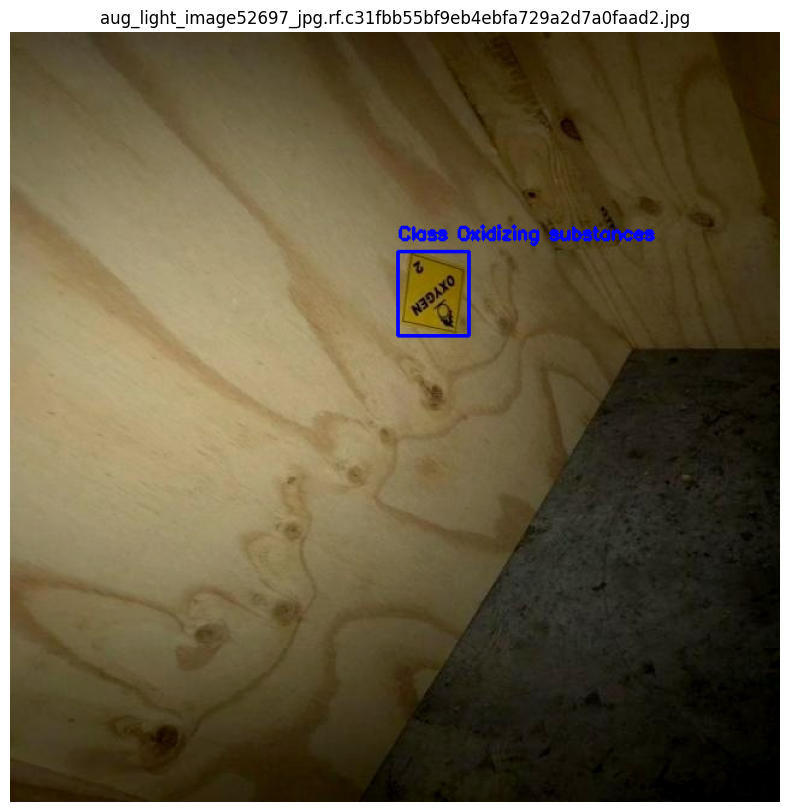

['38', '0.2310267835855484', '0.6607142686843872', '0.4486607015132904', '0.2857142686843872']
Class ID: 38, Class Name: Toxic gases
['34', '0.7868303656578064', '0.2916666567325592', '0.421875', '0.339285671710968']
Class ID: 34, Class Name: Poisons


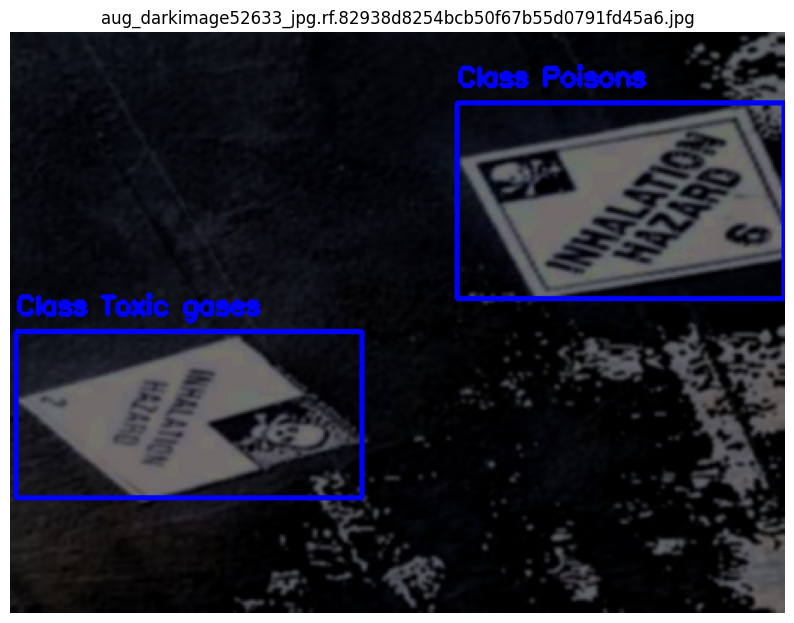

['37', '0.15937499701976776', '0.16953125596046448', '0.3187499940395355', '0.33906251192092896']
Class ID: 37, Class Name: Spontaneously combustible material
['34', '0.5171874761581421', '0.04218750074505806', '0.22187498211860657', '0.08437500149011612']
Class ID: 34, Class Name: Poisons
['34', '0.14374999701976776', '0.675000011920929', '0.14960935711860657', '0.12480473518371582']
Class ID: 34, Class Name: Poisons
['2', '0.6070312261581421', '0.8023437261581421', '0.12812495231628418', '0.09238278865814209']
Class ID: 2, Class Name: Corrosive
['2', '0.895312488079071', '0.9375', '0.13203120231628418', '0.08828127384185791']
Class ID: 2, Class Name: Corrosive


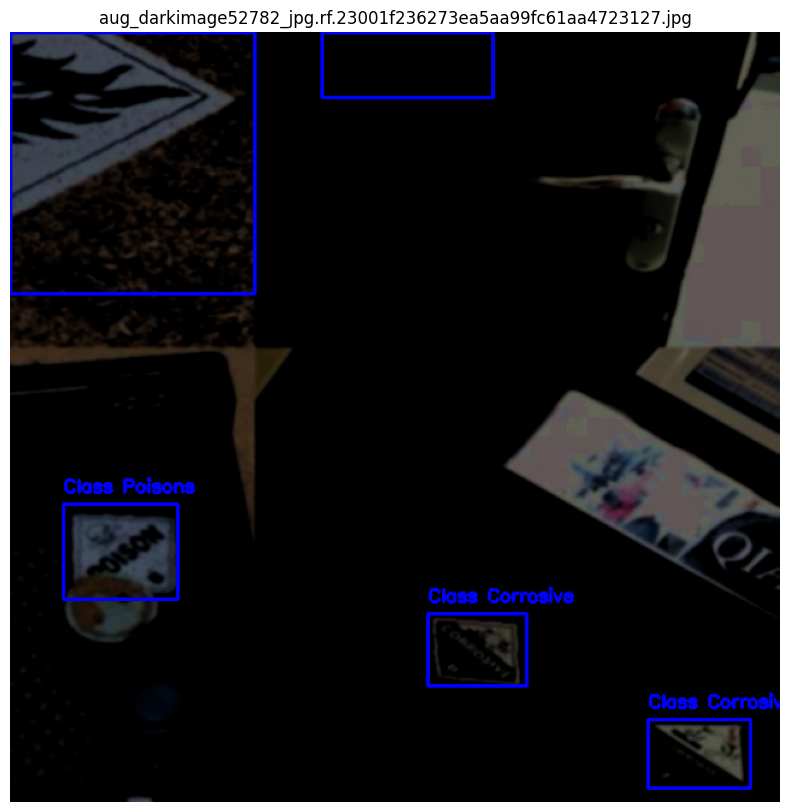

['4', '0.4437499940395355', '0.55078125', '0.16484373807907104', '0.3421875238418579']
Class ID: 4, Class Name: Dangerous when wet


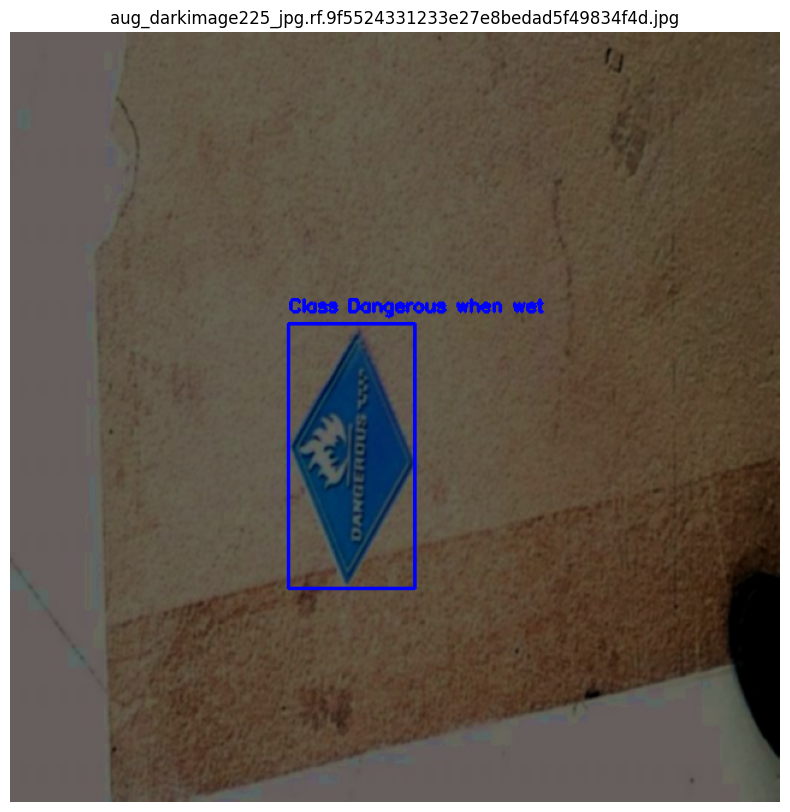

['11', '0.4686248302459717', '0.6579999923706055', '0.2323097288608551', '0.16999995708465576']
Class ID: 11, Class Name: Explosives Products with the potential to create a mass explosion


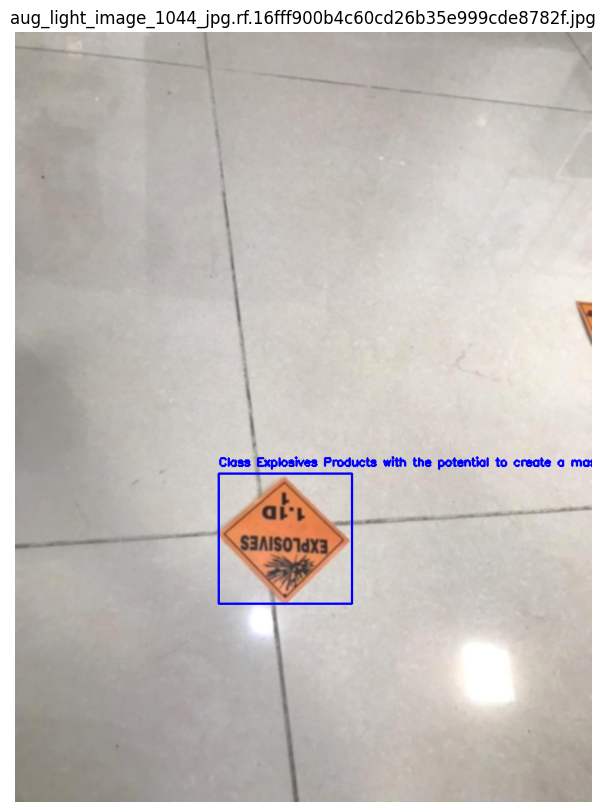

['30', '0.0390625', '0.02421874925494194', '0.078125', '0.04843749850988388']
Class ID: 30, Class Name: Oxidizing substances
['2', '0.723437488079071', '0.171875', '0.1625000238418579', '0.16582030057907104']
Class ID: 2, Class Name: Corrosive
['2', '0.680468738079071', '0.03125', '0.13593745231628418', '0.0625']
Class ID: 2, Class Name: Corrosive
['14', '0.23124998807907104', '0.567187488079071', '0.1064452975988388', '0.150390625']
Class ID: 14, Class Name: Flammable and combustible liquids
['5', '0.4085937440395355', '0.567187488079071', '0.09199219942092896', '0.1285156011581421']
Class ID: 5, Class Name: Environmentally Hazardous Substance
['23', '0.7109375', '0.625', '0.1275390386581421', '0.14042973518371582']
Class ID: 23, Class Name: Miscellaneous
['5', '0.47968751192092896', '0.612500011920929', '0.04062497615814209', '0.125']
Class ID: 5, Class Name: Environmentally Hazardous Substance


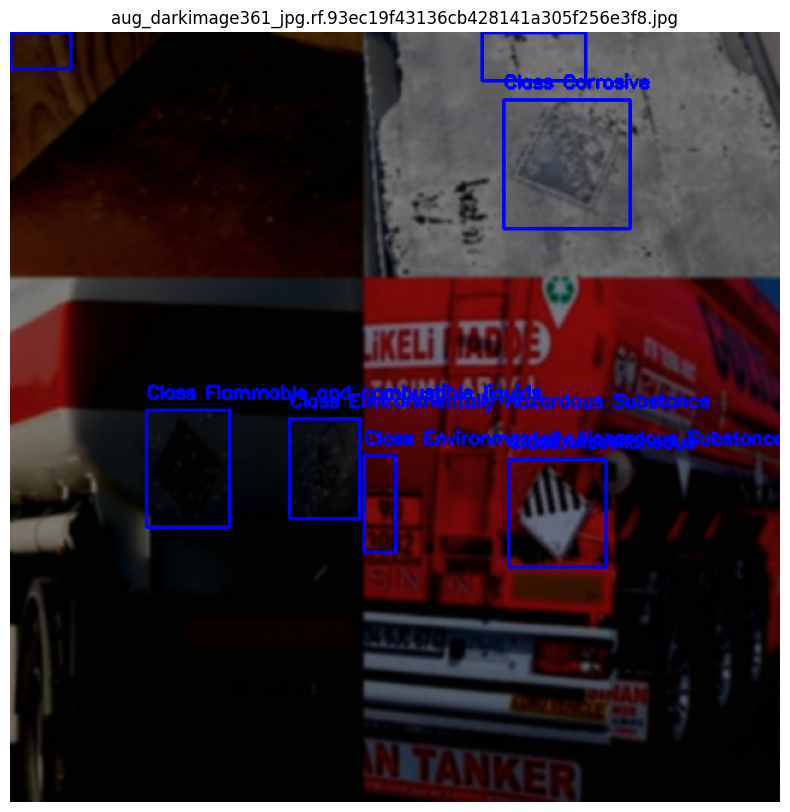

['17', '0.45234376192092896', '0.592968761920929', '0.23046875', '0.109375']
Class ID: 17, Class Name: Flammable solids
['13', '0.6226562261581421', '0.06328125298023224', '0.09531247615814209', '0.02656249701976776']
Class ID: 13, Class Name: Flammable
['17', '0.956250011920929', '0.42890626192092896', '0.07968747615814209', '0.053906261920928955']
Class ID: 17, Class Name: Flammable solids


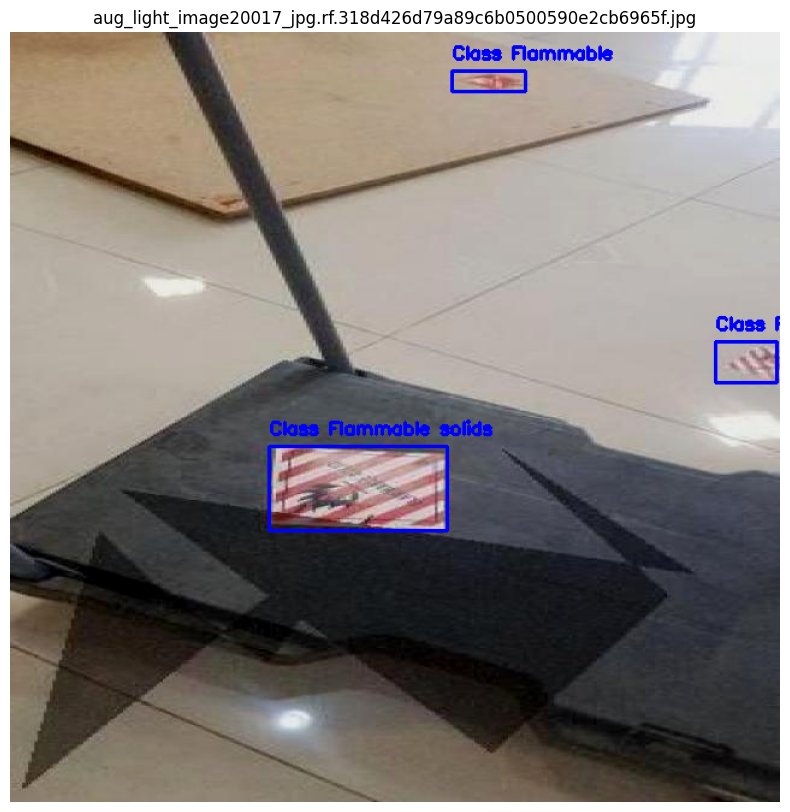

['34', '0.11562500149011612', '0.13828125596046448', '0.13984374701976776', '0.19863280653953552']
Class ID: 34, Class Name: Poisons
['34', '0.3570312559604645', '0.928906261920929', '0.17656248807907104', '0.1421874761581421']
Class ID: 34, Class Name: Poisons


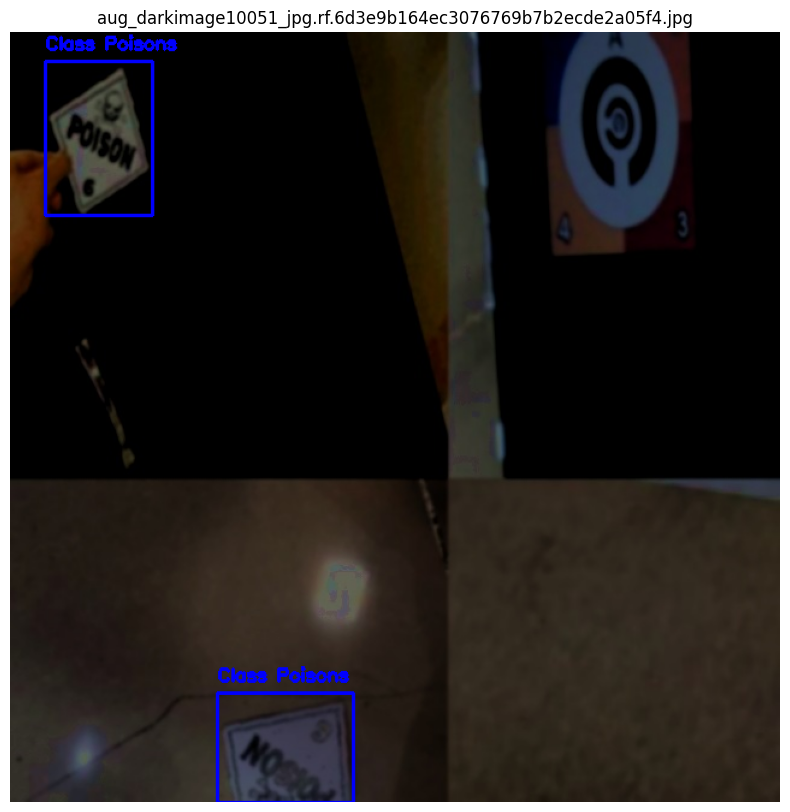

['15', '0.3727757930755615', '0.527999997138977', '0.3291814625263214', '0.16999998688697815']
Class ID: 15, Class Name: Flammable gases


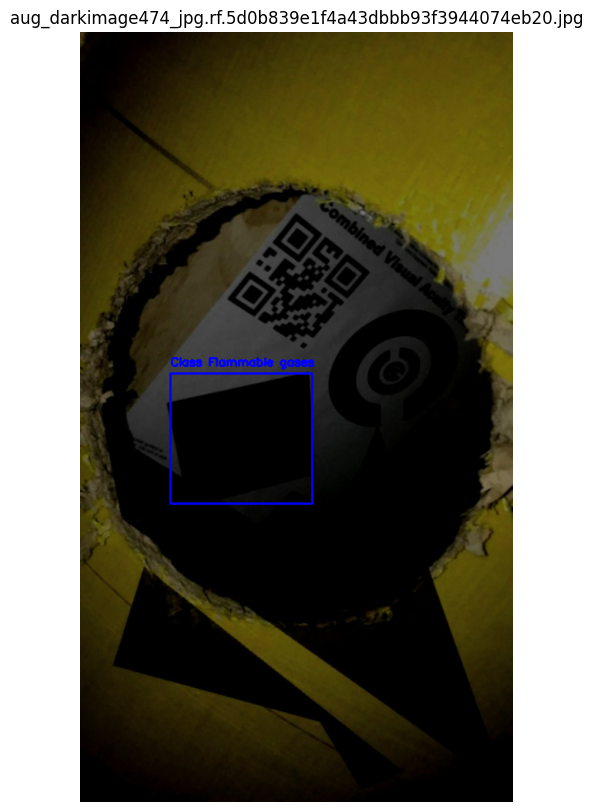

['25', '0.7291666865348816', '0.1935185194015503', '0.21770834922790527', '0.3870370388031006']
Class ID: 25, Class Name: Nonflammable gases
['36', '0.33020833134651184', '0.7384259104728699', '0.20937497913837433', '0.32870376110076904']
Class ID: 36, Class Name: Spontaneously combustible


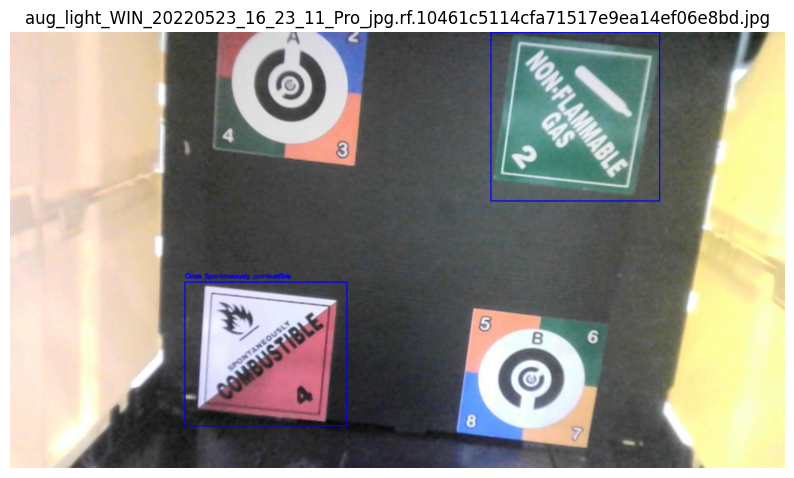

In [21]:
visualize_random_images('data_ogni/images_v1', 'data_ogni/labels', class_names=class_names,num_images=10)

In [4]:
print(len(class_names))

46


In [2]:
import os
from tqdm import tqdm

# Đường dẫn đến thư mục chứa các file nhãn YOLO
label_dir = "data_ogni/labels"

# Hàm kiểm tra và xóa các file không hợp lệ
def check_and_delete_yolo_labels(label_dir):
    files_with_at_least_5_values = 0  # Đếm số file hợp lệ với đúng 5 giá trị mỗi dòng
    files_deleted = 0  # Đếm số file bị xóa do có nhiều hơn 5 giá trị trong một dòng

    # Lấy danh sách tất cả file trong thư mục và hiển thị tiến trình với tqdm
    for label_file in tqdm(os.listdir(label_dir), desc="Checking label files"):
        if label_file.endswith(".txt"):
            label_path = os.path.join(label_dir, label_file)

            # Mở và kiểm tra từng dòng trong file
            with open(label_path, "r") as f:
                valid_file = True  # Giả định file hợp lệ cho đến khi tìm thấy dòng không hợp lệ
                
                for line in f.readlines():
                    values = line.strip().split()
                    if len(values) > 5:
                        valid_file = False  # File không hợp lệ, có hơn 5 giá trị trong một dòng
                        break  # Không cần kiểm tra thêm, file này sẽ bị xóa

            if valid_file:
                files_with_at_least_5_values += 1  # File hợp lệ
            else:
                os.remove(label_path)  # Xóa file không hợp lệ
                files_deleted += 1

    # In kết quả sau khi kiểm tra
    print(f"Số lượng file hợp lệ (đúng 5 giá trị mỗi dòng): {files_with_at_least_5_values}")
    print(f"Số lượng file bị xóa (nhiều hơn 5 giá trị mỗi dòng): {files_deleted}")

# Gọi hàm kiểm tra và xóa file
check_and_delete_yolo_labels(label_dir)


Checking label files: 100%|██████████| 9665/9665 [00:01<00:00, 7287.68it/s]

Số lượng file hợp lệ (đúng 5 giá trị mỗi dòng): 7792
Số lượng file bị xóa (nhiều hơn 5 giá trị mỗi dòng): 1873
